# Developing Well Calibrated Illness Severity Scores
## Model Analysis
### C.V. Cosgriff, MIT Critical Data

With our models developed, we will examine their discrimination and calibration. Discrimination will be examined via area under the reciever-operator characteristic curve (AUC). Calibration will be examined via reliability curves and observed-to-predicted mortality ratios. Metrics will have conservative 95% confidence intervals constructed via bootstrapping.

__Notebook Outline:__
* Envrionment preparation
* Load held out test set
* APACHE IV Evaluation
* Full Cohort Models
* High-risk Cohort Models
* Feature Analysis (Supplemental)
    
## 0 - Environement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance

import pickle

# "Tableau 20" colors as RGB for plotting
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - Models, Data, and Helper Functions

We first load up the fully trained models.

In [2]:
ridge_classifier = pickle.load(open('./models/ridge_full-cohort', 'rb'))
ridge_classifier_HR = pickle.load(open('./models/ridge_HR-cohort', 'rb'))
xgb_classifier = XGBClassifier()
xgb_classifier.load_model('./models/xgb_full-cohort')
xgb_classifier_HR = XGBClassifier()
xgb_classifier_HR.load_model('./models/xgb_HR-cohort')

We then load up the training and testing data. Note, we only need the training data for re-constructing the cohort for the APACHE IV graphics.

In [3]:
train_X = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').values
train_y = pd.read_csv('../extraction/data/train_y.csv').values.ravel()
train_apache = pd.read_csv('../extraction/data/train_apache.csv').values.ravel()

test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

We'll also need the high-risk testing cohort.

In [4]:
test_X_HR = test_X[(test_apache >= 0.10), :]
test_y_HR = test_y[test_apache >= 0.10]

Finally, we'll want some helper functions for calculating the CI for the metrics via bootstrapping.

In [5]:
def auc_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1 - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_auc = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        auc = roc_auc_score(y_true[indices], f_hat[indices])
        bootstrapped_auc.append(auc)

    sorted_scores = np.array(bootstrapped_auc)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_opr = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        opr = y_true[indices].mean() / f_hat[indices].mean()
        bootstrapped_opr.append(opr)

    sorted_scores = np.array(bootstrapped_opr)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper 

## 2 - APACHE IV Evaluation

We begin by evaluating APACHE IV discriminative ability in the entire cohort by generating an ROC curve.

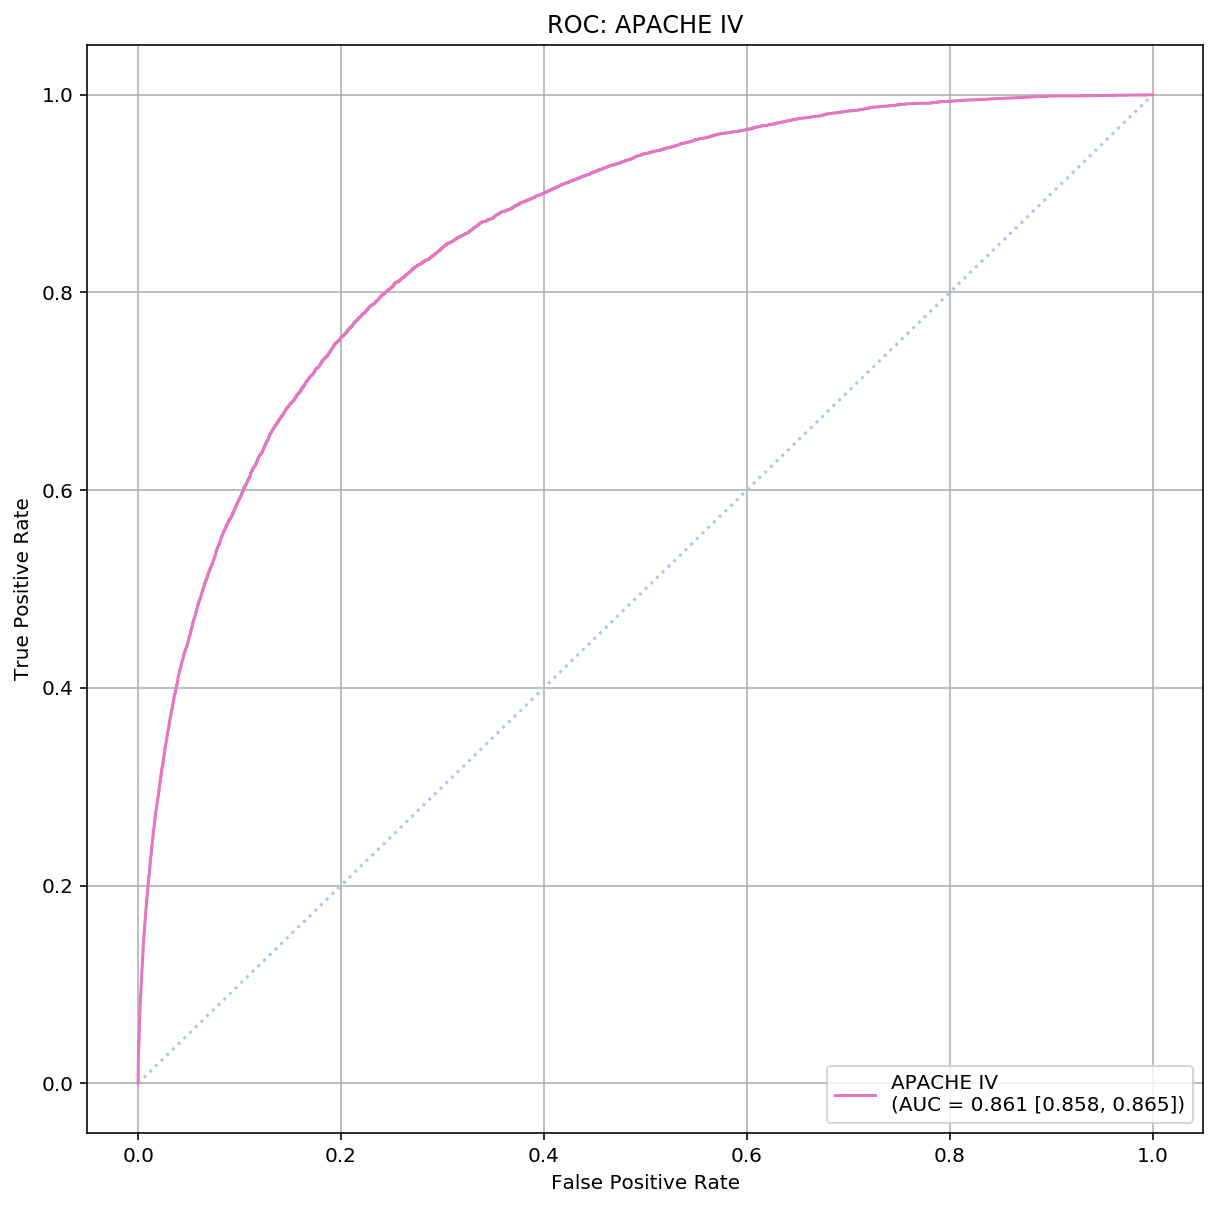

In [6]:
f_hat_apache = np.concatenate([train_apache, test_apache], axis=0)
y_true = np.concatenate([train_y, test_y], axis=0)
roc_apache = roc_curve(y_true, f_hat_apache)
auc_apache = roc_auc_score(y_true, f_hat_apache)

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
plt.plot(roc_apache[0], roc_apache[1], color=tableau20[12], 
         label='APACHE IV\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_apache, *auc_ci(f_hat_apache, y_true)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: APACHE IV')
plt.legend(loc="lower right")

plt.savefig('./figures/roc-apache_whole.svg', bbox_inches='tight')
plt.grid()
plt.show()

We then examine its calibration via a reliability curve.

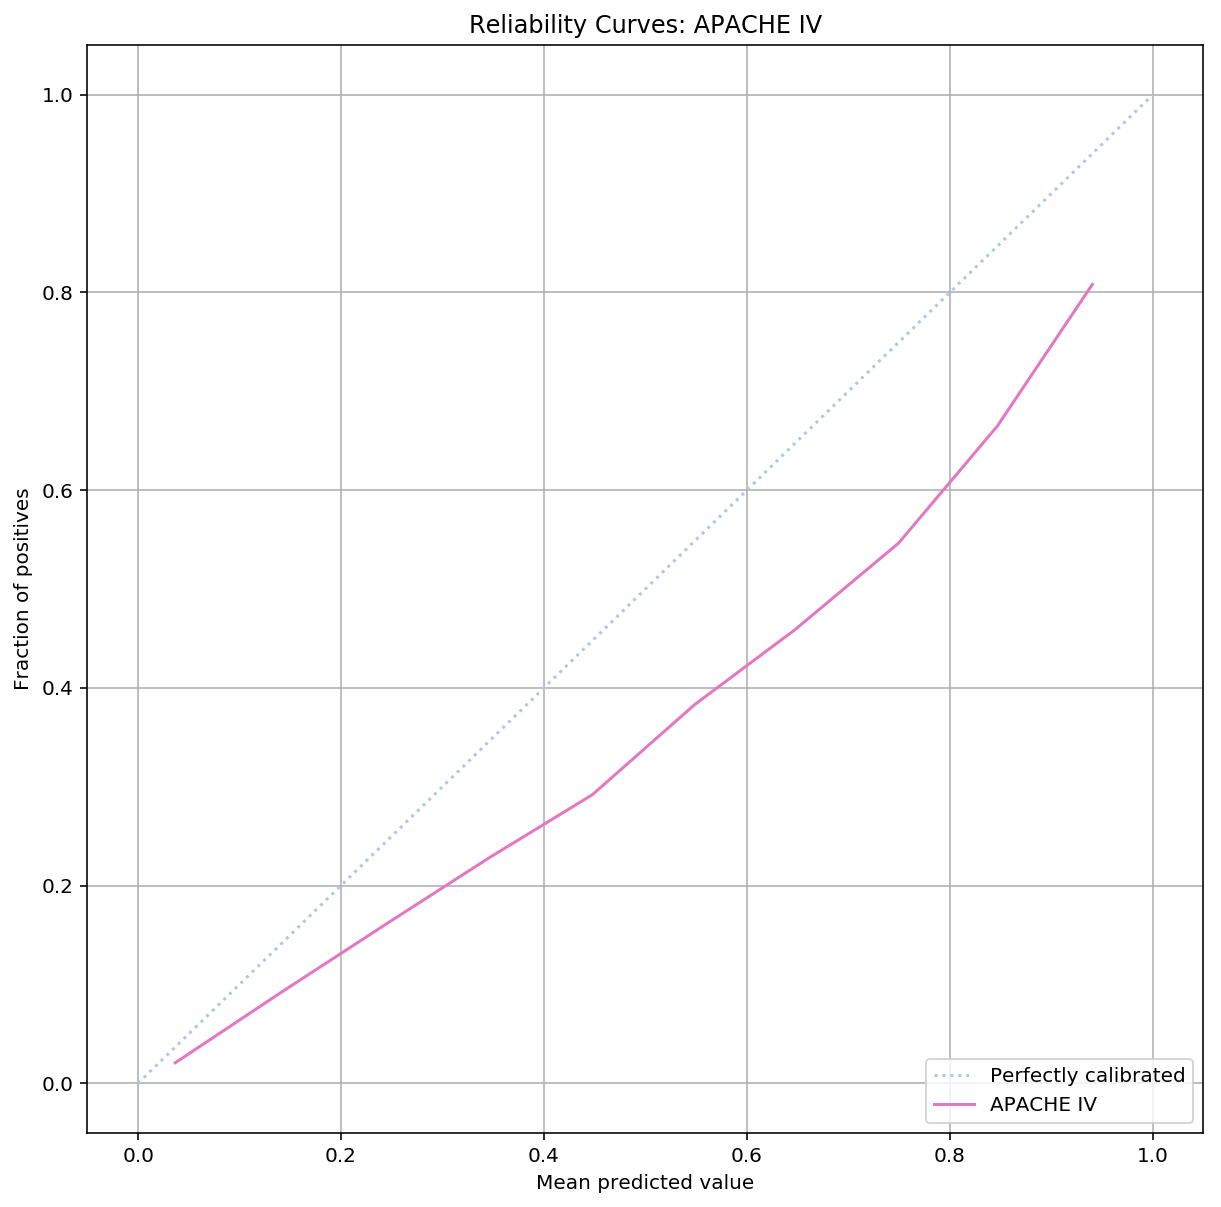

In [7]:
fraction_of_positives_apache, mean_predicted_value_apache = calibration_curve(y_true, f_hat_apache, n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[1])

ax1.plot(mean_predicted_value_apache, fraction_of_positives_apache, color=tableau20[12], 
         label='APACHE IV')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curves: APACHE IV')
ax1.set_xlabel("Mean predicted value")

plt.grid()
plt.savefig('./figures/calib-apache_whole.svg', bbox_inches='tight')
plt.show()

In [8]:
print('APACHE IVa OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(y_true.mean()/f_hat_apache.mean(), *op_ratio_ci(f_hat_apache, y_true)))

APACHE IVa OPR: 0.670 [0.659, 0.682]


## 3 - Models Fit in the Entire Cohort

Here we will examine how the models trained in the full cohort perform and how this performance changes when examine a cohort composed of only high-risk patients.

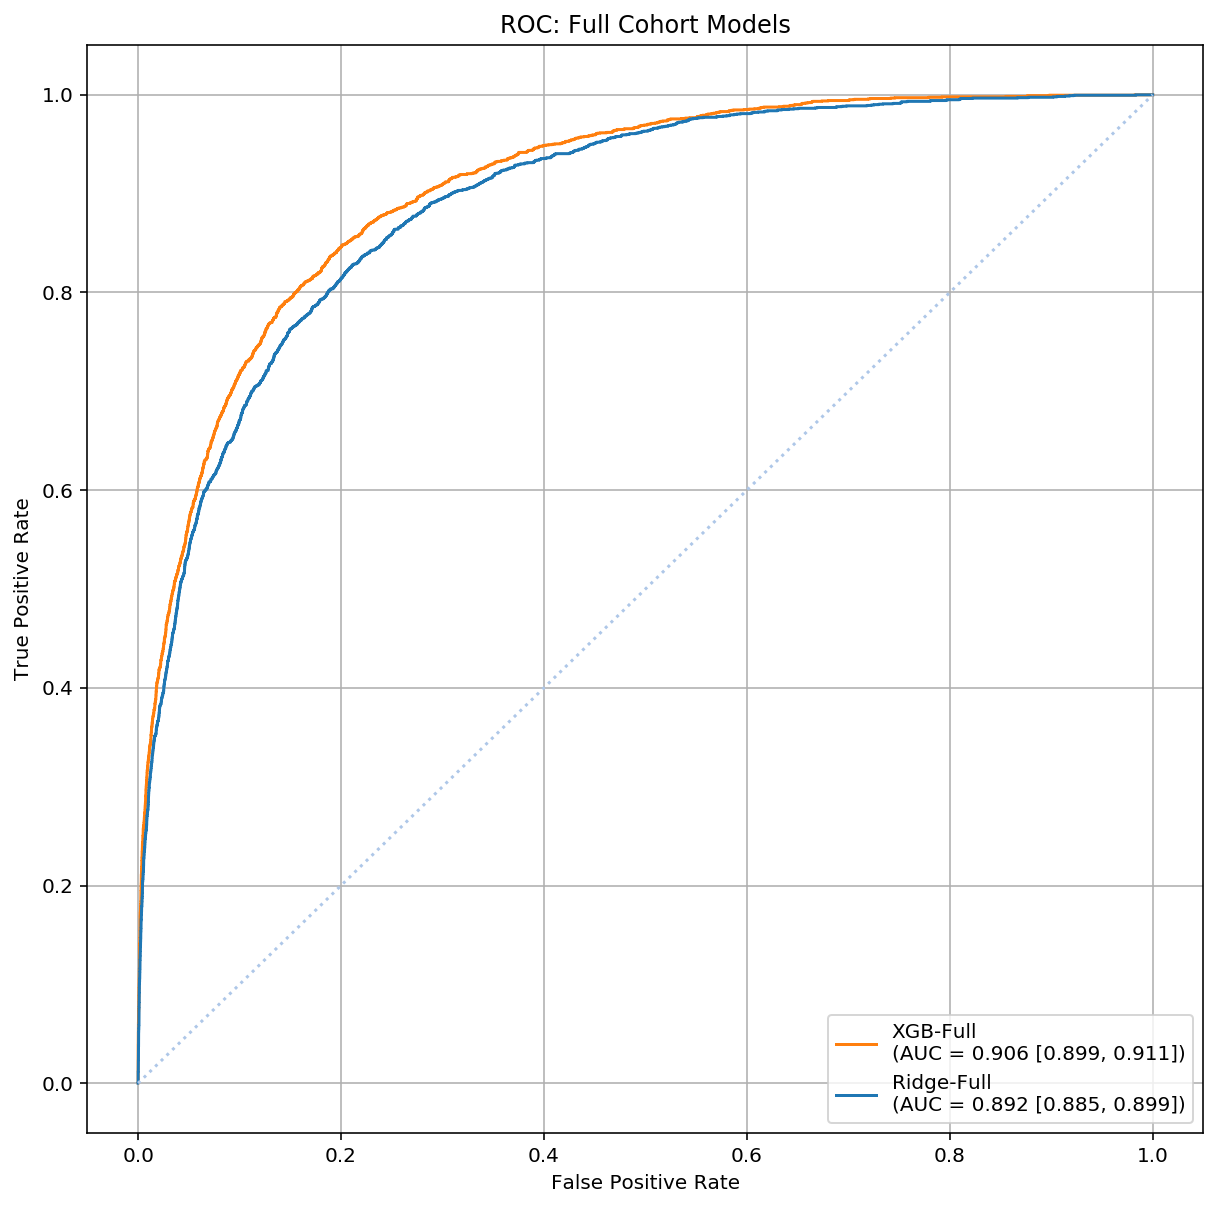

In [9]:
f_hat_ridge = ridge_classifier.predict_proba(test_X)
roc_ridge = roc_curve(test_y, f_hat_ridge[:, 1])
auc_ridge = roc_auc_score(test_y, f_hat_ridge[:, 1])

f_hat_xgb = xgb_classifier.predict_proba(test_X)
roc_xgb = roc_curve(test_y, f_hat_xgb[:, 1])
auc_xgb = roc_auc_score(test_y, f_hat_xgb[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(roc_xgb[0], roc_xgb[1], color=tableau20[2], 
         label='XGB-Full\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_xgb, *auc_ci(f_hat_xgb[:, 1], test_y)))
plt.plot(roc_ridge[0], roc_ridge[1], color=tableau20[0], 
         label='Ridge-Full\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_ridge, *auc_ci(f_hat_ridge[:, 1], test_y)))

plt.grid()
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Full Cohort Models')
plt.legend(loc="lower right")

# plt.savefig('./figures/roc-full.svg', bbox_inches='tight')
plt.show()

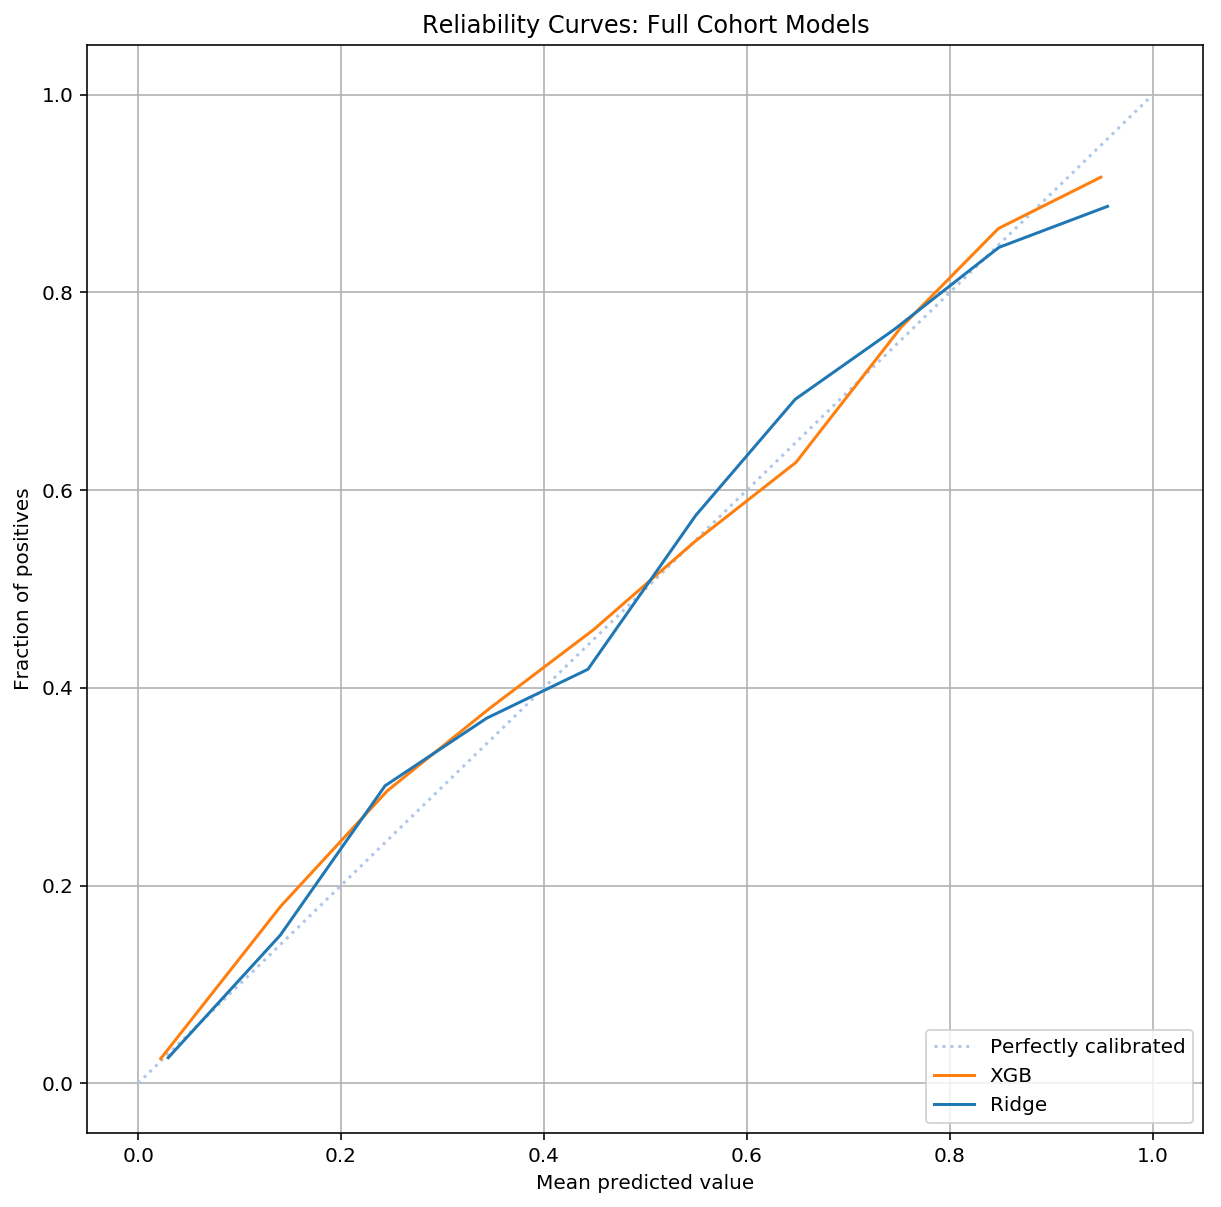

In [10]:
fraction_of_positives_ridge, mean_predicted_value_ridge = calibration_curve(test_y, f_hat_ridge[:, 1], n_bins=10)
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(test_y, f_hat_xgb[:, 1], n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[1])

ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, color=tableau20[2], 
         label='XGB')
ax1.plot(mean_predicted_value_ridge, fraction_of_positives_ridge, color=tableau20[0], 
         label='Ridge')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curves: Full Cohort Models')
ax1.set_xlabel("Mean predicted value")

# plt.savefig('./figures/calib-full.svg', bbox_inches='tight')
plt.grid()
plt.show()

In [11]:
print('Ridge OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y.mean()/f_hat_ridge[:, 1].mean(), *op_ratio_ci(f_hat_ridge[:, 1], test_y)))
print('XGB OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y.mean()/f_hat_xgb[:, 1].mean(), *op_ratio_ci(f_hat_xgb[:, 1], test_y)))

Ridge OPR: 1.009 [0.976, 1.041]
XGB OPR: 1.092 [1.057, 1.125]


We then reproduce these analyses in the high-risk sub-cohort.

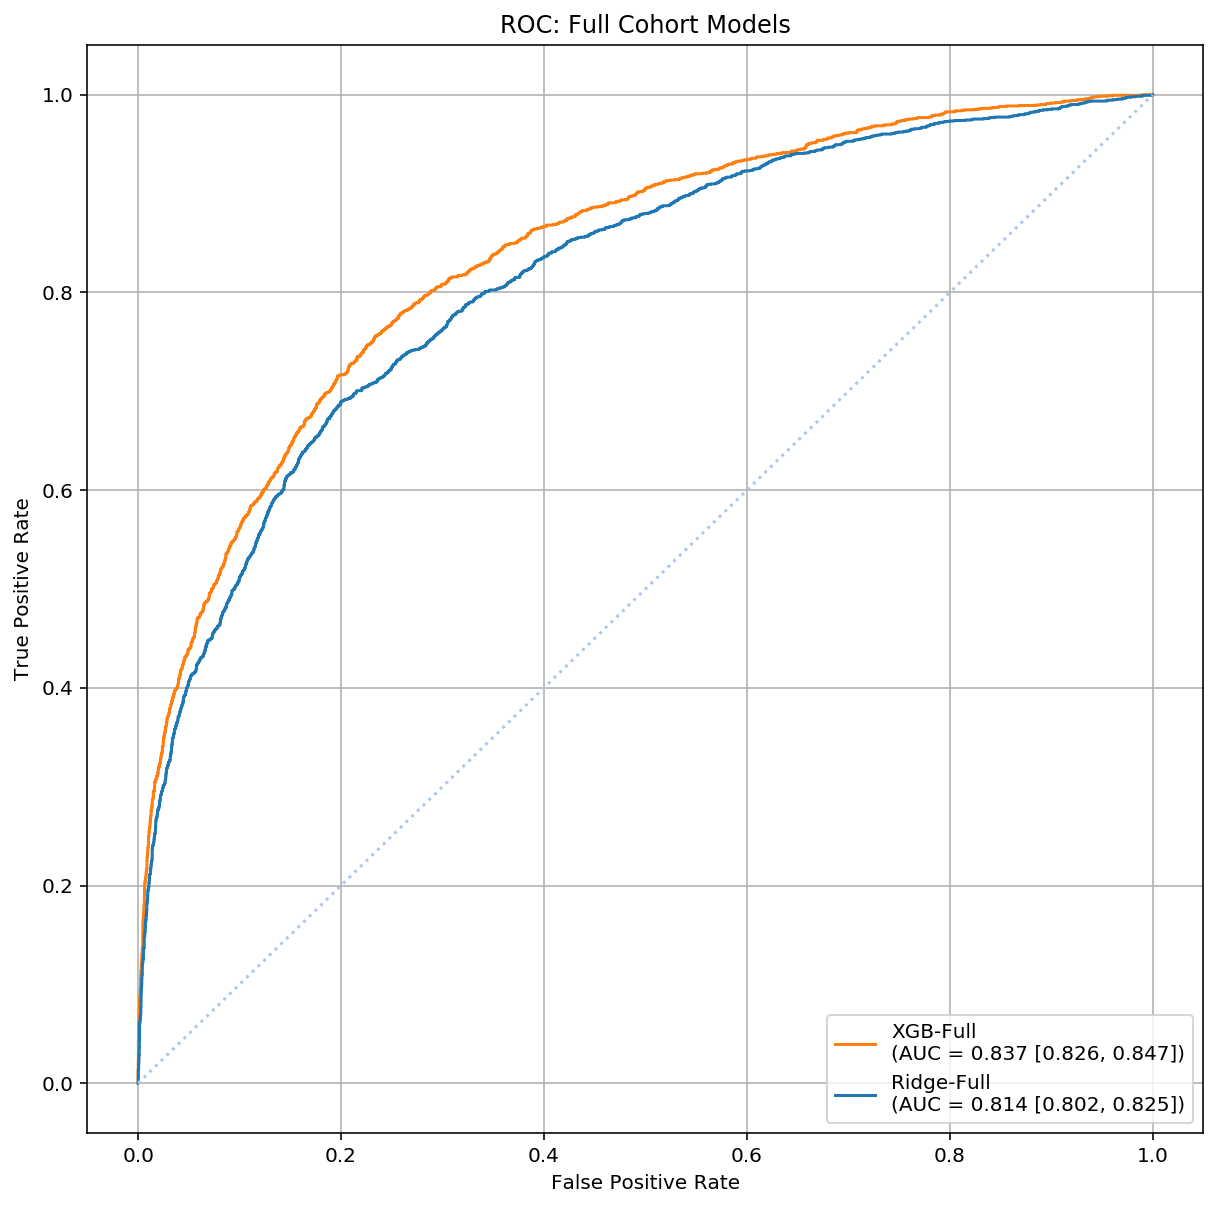

In [12]:
f_hat_ridge = ridge_classifier.predict_proba(test_X_HR)
roc_ridge = roc_curve(test_y_HR, f_hat_ridge[:, 1])
auc_ridge = roc_auc_score(test_y_HR, f_hat_ridge[:, 1])

f_hat_xgb = xgb_classifier.predict_proba(test_X_HR)
roc_xgb = roc_curve(test_y_HR, f_hat_xgb[:, 1])
auc_xgb = roc_auc_score(test_y_HR, f_hat_xgb[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(roc_xgb[0], roc_xgb[1], color=tableau20[2], 
         label='XGB-Full\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_xgb, *auc_ci(f_hat_xgb[:, 1], test_y_HR)))
plt.plot(roc_ridge[0], roc_ridge[1], color=tableau20[0], 
         label='Ridge-Full\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_ridge, *auc_ci(f_hat_ridge[:, 1], test_y_HR)))

plt.grid()
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Full Cohort Models')
plt.legend(loc="lower right")

# plt.savefig('./figures/roc-full.svg', bbox_inches='tight')
plt.show()

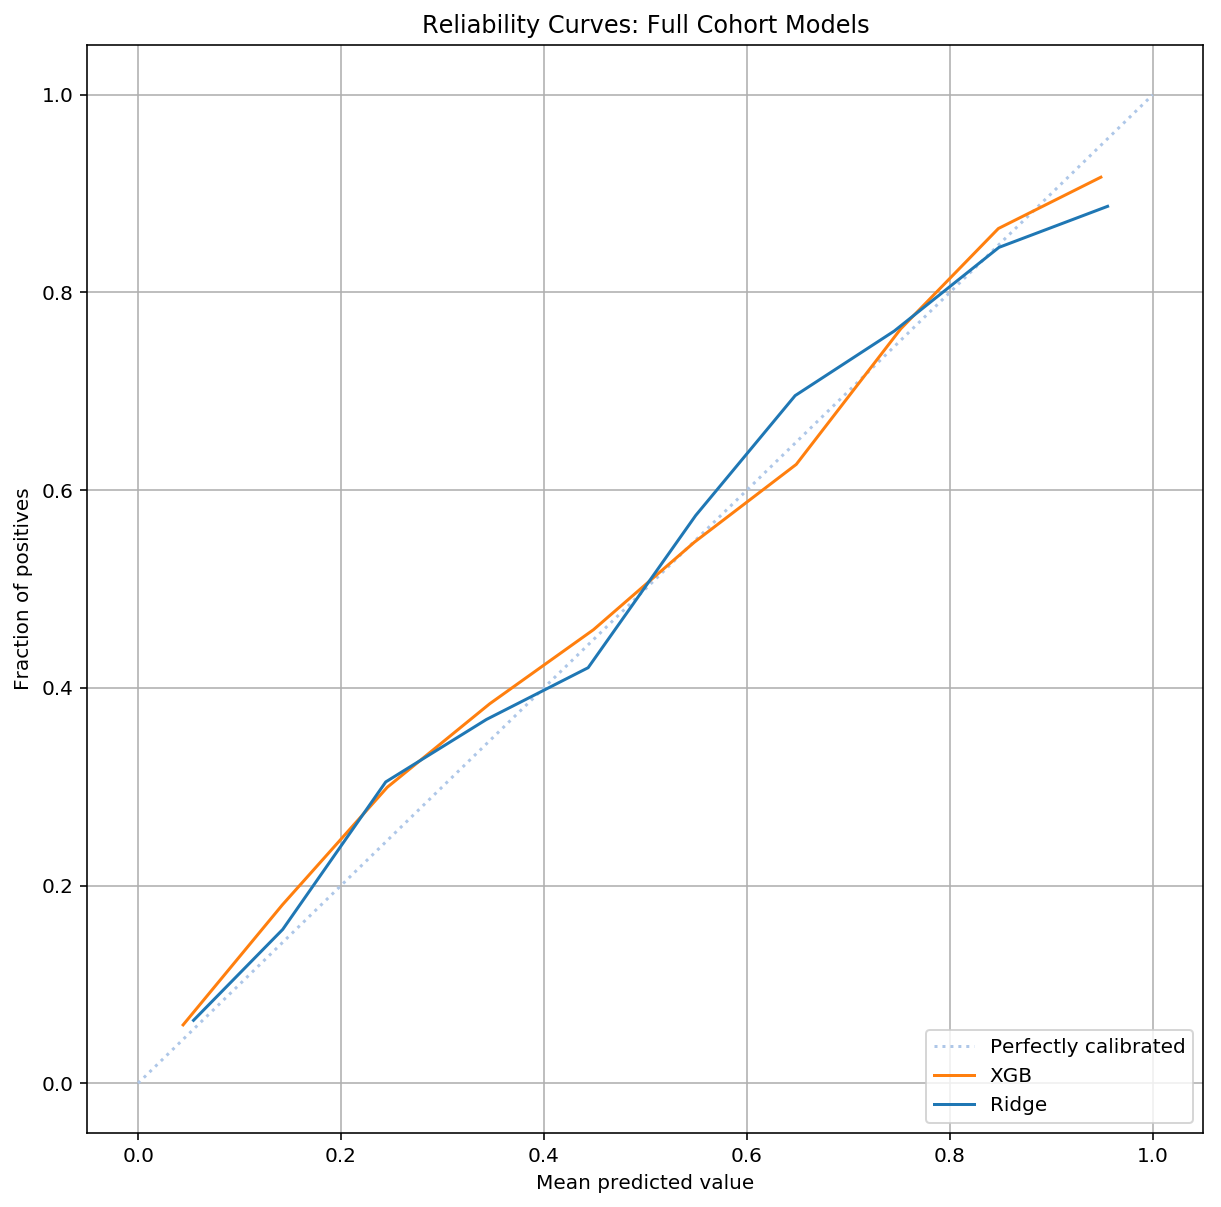

In [13]:
fraction_of_positives_ridge, mean_predicted_value_ridge = calibration_curve(test_y_HR, f_hat_ridge[:, 1], n_bins=10)
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(test_y_HR, f_hat_xgb[:, 1], n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[1])

ax1.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, color=tableau20[2], 
         label='XGB')
ax1.plot(mean_predicted_value_ridge, fraction_of_positives_ridge, color=tableau20[0], 
         label='Ridge')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curves: Full Cohort Models')
ax1.set_xlabel("Mean predicted value")

# plt.savefig('./figures/calib-full.svg', bbox_inches='tight')
plt.grid()
plt.show()

In [14]:
print('Ridge OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_ridge[:, 1].mean(), *op_ratio_ci(f_hat_ridge[:, 1], test_y_HR)))
print('XGB OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_xgb[:, 1].mean(), *op_ratio_ci(f_hat_xgb[:, 1], test_y_HR)))

Ridge OPR: 1.074 [1.038, 1.112]
XGB OPR: 1.110 [1.073, 1.148]


## 4 - Models Fit in the High-risk Sub-Cohort

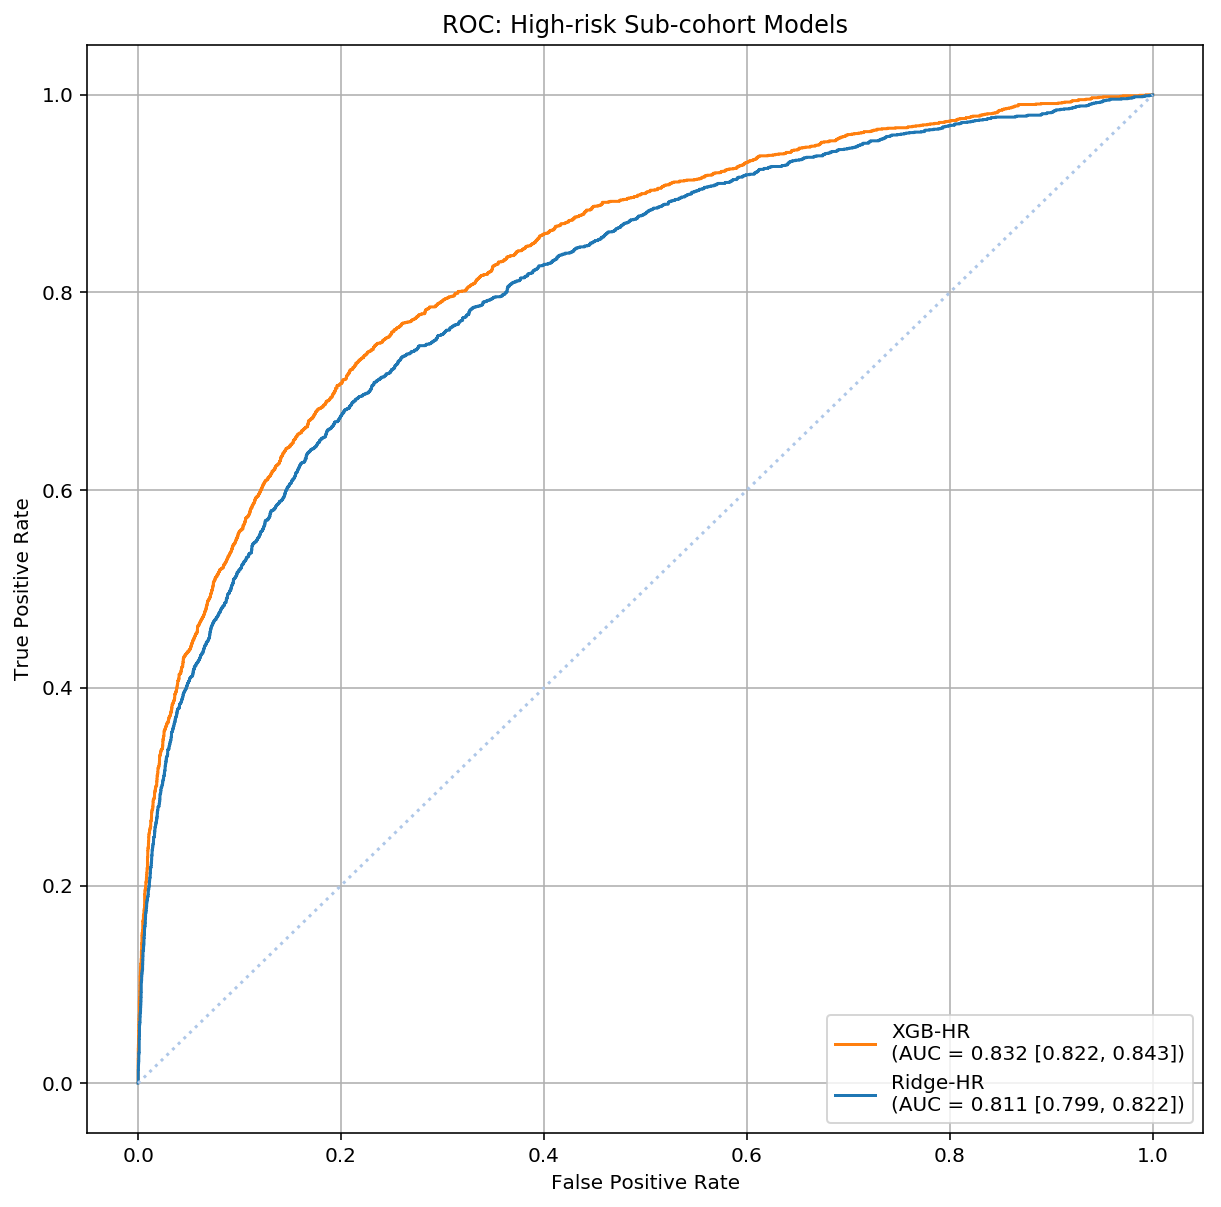

In [23]:
f_hat_ridge_HR = ridge_classifier_HR.predict_proba(test_X_HR)
roc_ridge_HR = roc_curve(test_y_HR, f_hat_ridge_HR[:, 1])
auc_ridge_HR = roc_auc_score(test_y_HR, f_hat_ridge_HR[:, 1])

f_hat_xgb_HR = xgb_classifier_HR.predict_proba(test_X_HR)
roc_xgb_HR = roc_curve(test_y_HR, f_hat_xgb_HR[:, 1])
auc_xgb_HR = roc_auc_score(test_y_HR, f_hat_xgb_HR[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(roc_xgb_HR[0], roc_xgb_HR[1], color=tableau20[2], 
         label='XGB-HR\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_xgb_HR, *auc_ci(f_hat_xgb_HR[:, 1], test_y_HR)))
plt.plot(roc_ridge_HR[0], roc_ridge_HR[1], color=tableau20[0], 
         label='Ridge-HR\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_ridge_HR, *auc_ci(f_hat_ridge_HR[:, 1], test_y_HR)))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: High-risk Sub-cohort Models')
plt.legend(loc="lower right")

# plt.savefig('./figures/roc-hr.svg', bbox_inches='tight')
plt.grid()
plt.show()

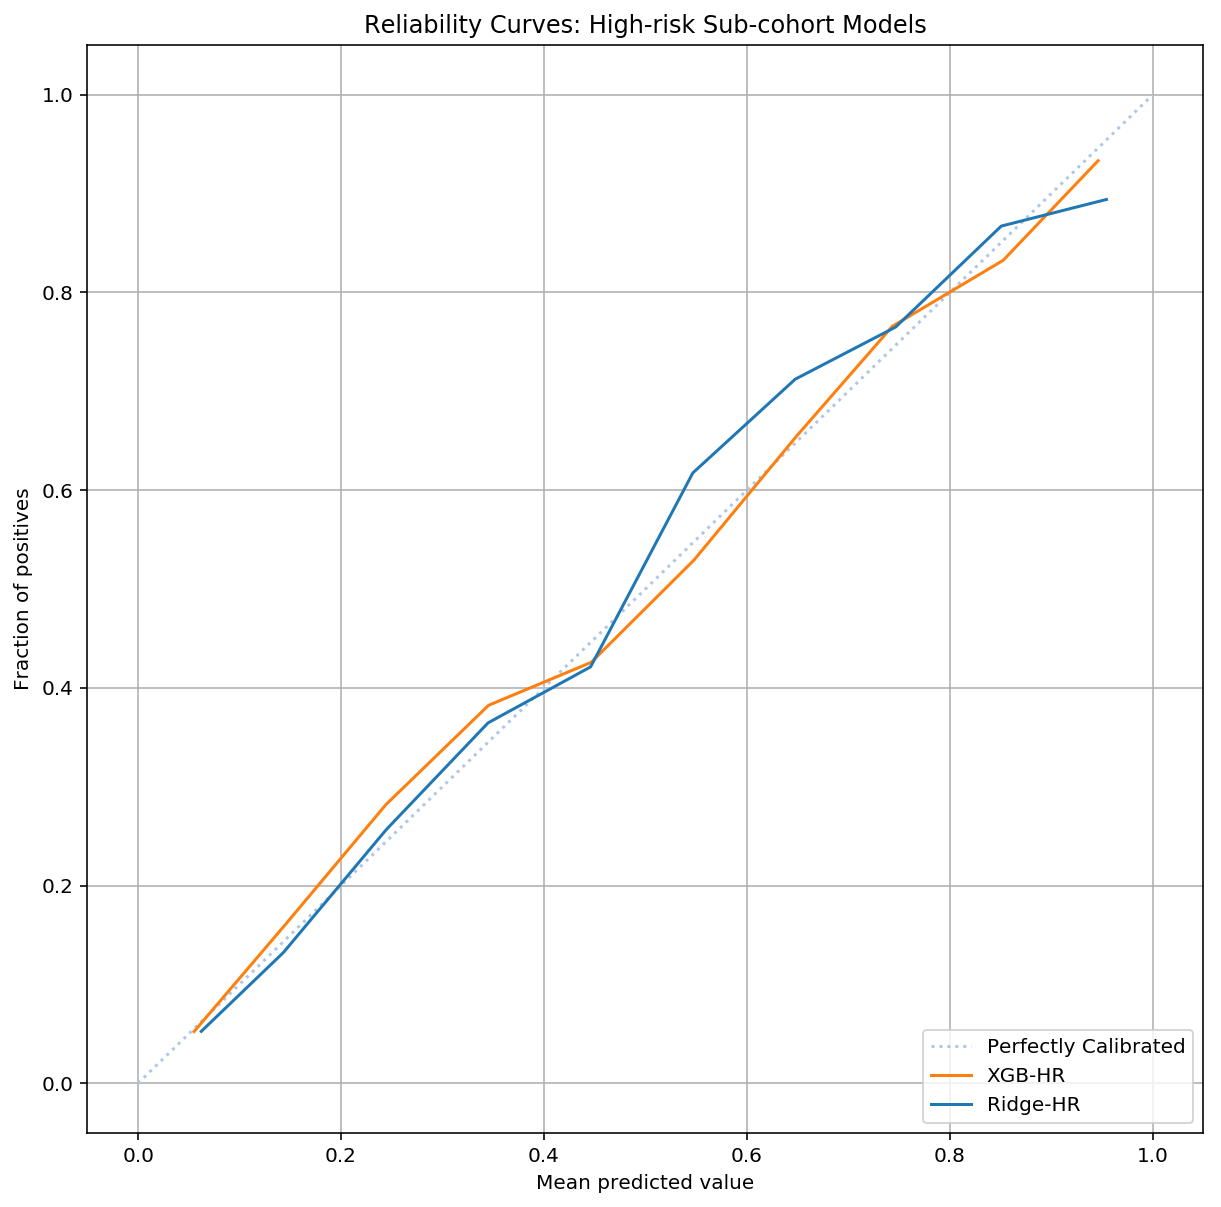

In [24]:
fraction_of_positives_ridge_HR, mean_predicted_value_ridge_HR = calibration_curve(test_y_HR, f_hat_ridge_HR[:, 1], n_bins=10)
fraction_of_positives_xgb_HR, mean_predicted_value_xgb_HR = calibration_curve(test_y_HR, f_hat_xgb_HR[:, 1], n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated", color=tableau20[1])

ax1.plot(mean_predicted_value_xgb_HR, fraction_of_positives_xgb_HR, color=tableau20[2], 
         label='XGB-HR')
ax1.plot(mean_predicted_value_ridge_HR, fraction_of_positives_ridge_HR, color=tableau20[0], 
         label='Ridge-HR')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('Reliability Curves: High-risk Sub-cohort Models')
ax1.set_xlabel("Mean predicted value")
# plt.savefig('./figures/calib-hr.svg', bbox_inches='tight')
plt.grid()
plt.show()

In [17]:
print('Ridge OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_ridge_HR[:, 1].mean(), *op_ratio_ci(f_hat_ridge_HR[:, 1], test_y_HR)))
print('XGB OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(test_y_HR.mean()/f_hat_xgb_HR[:, 1].mean(), *op_ratio_ci(f_hat_xgb_HR[:, 1], test_y_HR)))

Ridge OPR: 0.993 [0.959, 1.027]
XGB OPR: 1.033 [0.998, 1.068]


## 5 - Feature Analysis (Supplemental)

The features of the ridge models may be examined via the odds ratios associated with each feature. Similary, although not directly comparable, the importance matrix of the gradient boosted models may provide insight. These will likely be part of supplemental materials and not part of the main analysis as the audidence is clinical.

We first extract the feature names.

In [18]:
feature_names = pd.read_csv('../extraction/data/train_X.csv').set_index('patientunitstayid').columns

For the ridge models, we'll manually extract the coefficient array, which has its order preserved, and assign the feature names so that we can easily read the sorted list. We examine the full cohort model first.

In [19]:
ridge_coef = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier.named_steps['ridge'].coef_.ravel())}
ridge_coef = pd.DataFrame.from_dict(ridge_coef, orient='index', columns=['odds_ratio'])
ridge_coef.reindex(ridge_coef.odds_ratio.abs().sort_values(ascending=False).index).iloc[0:20, :]

,odds_ratio
age,1.472266
hr_mean,1.275194
rr_mean,1.246362
adx_CVASTROKE,1.234511
adx_CARDARREST,1.232247
adx_ICH,1.222641
apache_ventday1,1.189612
lactate_max,1.176282
apache_active_tx,1.161060
pressor,1.125846


And then we turn to the subcohort model.

In [20]:
ridge_coef_HR = {k:np.exp(v) for k, v in zip(feature_names, ridge_classifier_HR.named_steps['ridge'].coef_.ravel())}
ridge_coef_HR = pd.DataFrame.from_dict(ridge_coef_HR, orient='index', columns=['odds_ratio'])
ridge_coef_HR.reindex(ridge_coef_HR.odds_ratio.abs().sort_values(ascending=False).index).iloc[0:20, :]

,odds_ratio
age,1.296844
adx_CARDARREST,1.263530
hr_mean,1.237433
adx_ICH,1.217730
rr_mean,1.216088
lactate_max,1.215102
adx_CVASTROKE,1.172589
apache_ventday1,1.159501
pressor,1.157447
apache_active_tx,1.129379


The top 20 features in both by OR magnitude are similar for both the full and subcohort models, and, intuitevly we note certain features in the high-risk model that we would expect to see with more prevalence in a sicker cohort e.g. metastasis (`mets`).

We next turn to the XGB models. For these we'll need to map the feature names onto the models internal representation of the features and thene xtract the importance matrices. Again we start with the full cohort models. XGB also provides a nice function for visualizing the matrix.

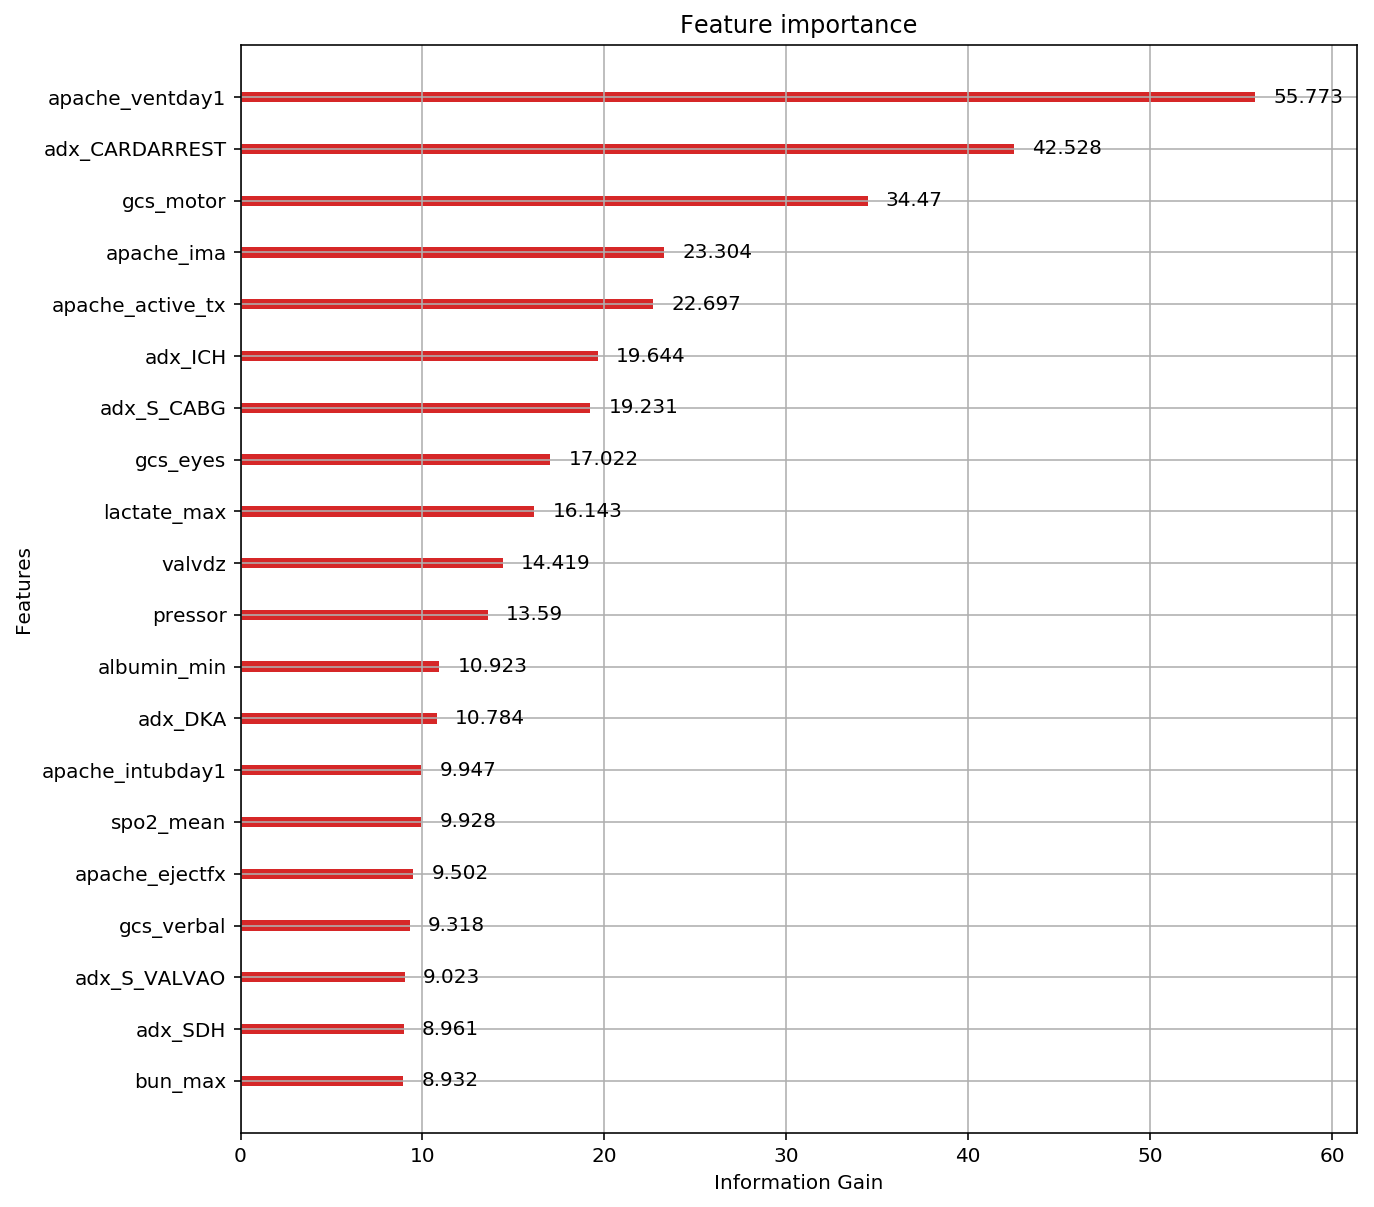

In [21]:
mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', xlabel='Information Gain', ax=plt.axes())
plt.show()

Using the same mapper, we can generate the same result for the high-risk subcohort XGB model.

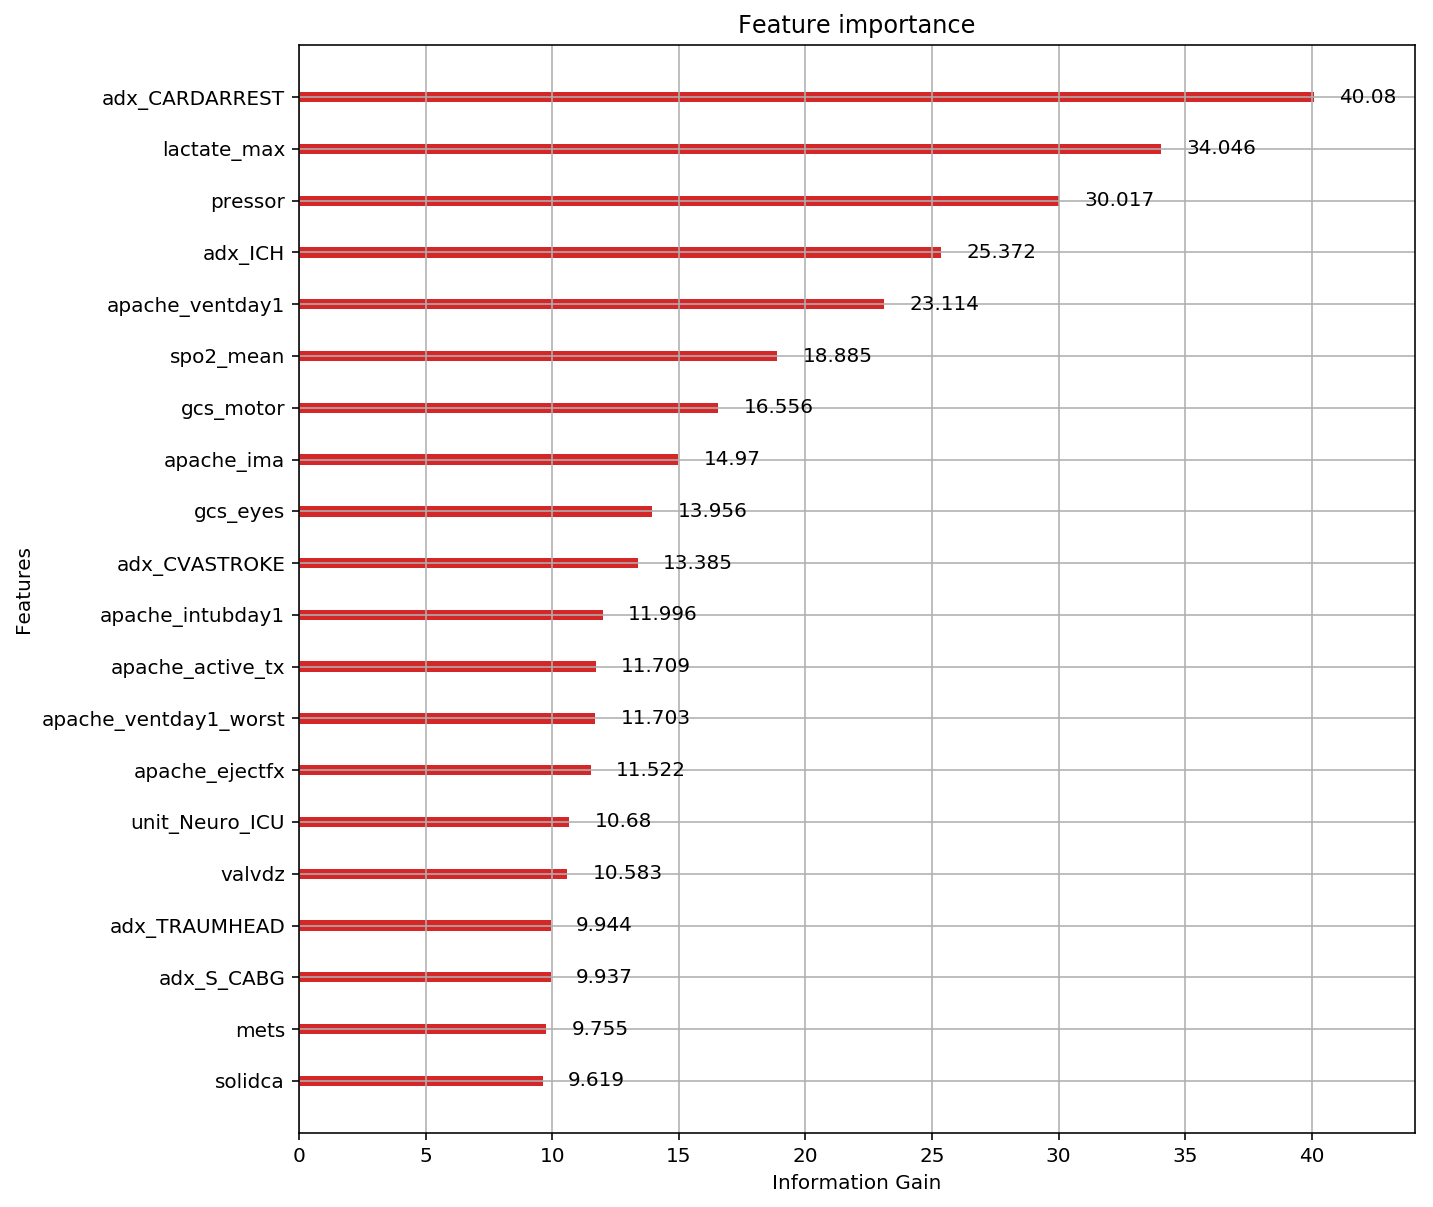

In [22]:
imp_matrix = {mapper[k]: round(v, 3) for k, v in xgb_classifier_HR.get_booster().get_score(importance_type='gain').items()}
plt.figure(figsize=(10, 10))
plot_importance(imp_matrix, max_num_features=20, color=tableau20[6], importance_type='gain', xlabel='Information Gain', ax=plt.axes())
plt.show()

We note similarity between these features and the ridge features and substantial overlap between the XGB full and high-risk models. Overall we have a pretty good intuition as to why these are the biggest contributions, and differences between full and high-risk subcohort models are not marked.